In [ ]:
import copy
from datetime import datetime as time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gradient_boosting import (GradientBoostingRegressor,
                               StochasticGradientBoostingRegressor)
from sklearn.ensemble import \
    GradientBoostingRegressor as SklearnGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv("../assets/auto-mpg.csv") # mpg - расход топлива (miles per gallon)

data = data.drop(["car name", "origin"], axis=1)

data["horsepower"] = data["horsepower"].replace({"?": np.nan}).astype(np.float32)
mean_hp = np.nanmean(data["horsepower"])
data["horsepower"] = data["horsepower"].fillna(mean_hp).astype(np.uint16)

data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,18.0,8,307.0,130,3504,12.0,70
1,15.0,8,350.0,165,3693,11.5,70
2,18.0,8,318.0,150,3436,11.0,70
3,16.0,8,304.0,150,3433,12.0,70
4,17.0,8,302.0,140,3449,10.5,70


In [4]:
y = data[["mpg"]].to_numpy().ravel()
X = data.drop(["mpg"], axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((318, 6), (80, 6))

In [27]:
y_train.shape

(318,)

## custom

In [310]:
def loss(y_true, y_pred):
    return 1/(len(y_true)) * 0.5 * np.sum(np.square(y_true-y_pred))

def grad(y_true, y_pred):
    return - (y_true - y_pred)

In [325]:
boosting_model = GradientBoostingRegressor(loss, grad, lr=0.05)

t1_custom = time.now()
boosting_model.fit(X_train, y_train.reshape(-1, 1))
t2_custom = time.now()

y_pred = boosting_model.predict(X_test)
print(f"Number of iterations: {boosting_model.num_iterations}")
print(f"R2-score: {r2_score(y_test, y_pred):.5f}")

Number of iterations: 187
R2-score: 0.86032


In [330]:
stochastic_model = StochasticGradientBoostingRegressor(loss, grad, lr=0.05)

t1_stoch = time.now()
stochastic_model.fit(X_train, y_train.reshape(-1, 1))
t2_stoch = time.now()

y_pred = stochastic_model.predict(X_test)
print(f"Number of iterations: {stochastic_model.num_iterations}")
print(f"R2-score: {r2_score(y_test, y_pred):.5f}")

Number of iterations: 237
R2-score: 0.87198


## sklearn

In [331]:
sklearn_model = SklearnGradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)
t1_sklearn = time.now()
sklearn_model.fit(X_train, y_train)
t2_sklearn = time.now()

y_pred_sk = sklearn_model.predict(X_test)
r2_score(y_test, y_pred_sk)

0.8802988842745222

## compare

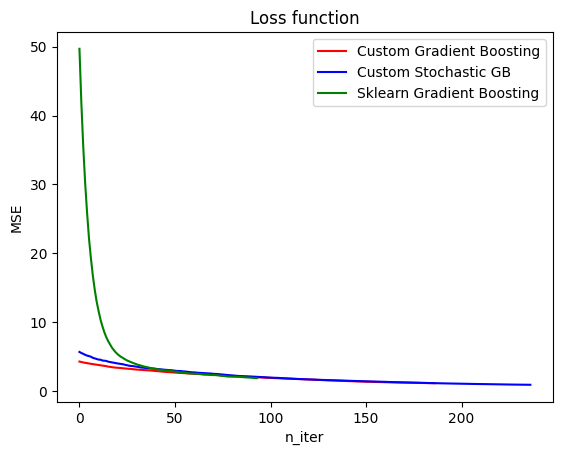

In [332]:
plt.plot(boosting_model.losses, c='red', label="Custom Gradient Boosting")
plt.plot(stochastic_model.losses, c='blue', label='Custom Stochastic GB')

plt.plot(sklearn_model.train_score_, c='green', label='Sklearn Gradient Boosting')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("n_iter")
plt.title("Loss function")

plt.savefig("../assets/loss_func.png", bbox_inches="tight")

In [314]:
print(f"Время, затраченное кастомным алгоритмом на {boosting_model.num_iterations} итераций: {(t2_custom - t1_custom).microseconds / 1000:.3f} мс")
print(f"Время, затраченное кастомным стохастическим алгоритмом на {stochastic_model.num_iterations} итераций: {(t2_stoch - t1_stoch).microseconds / 1000:.3f} мс")
print(f"Время, затраченное Sklearn алгоритмом на {sklearn_model.n_estimators_} итераций: {(t2_sklearn - t1_sklearn).microseconds / 1000:.3f} мс")

Время, затраченное кастомным алгоритмом на 187 итераций: 341.009 мс
Время, затраченное кастомным стохастическим алгоритмом на 199 итераций: 482.992 мс
Время, затраченное Sklearn алгоритмом на 56 итераций: 87.965 мс


In [315]:
def cross_validate(model, X, y, n_folds=5):
    scores = []
    for n in range(n_folds):
        model2fit = copy.deepcopy(model)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model2fit.fit(X_train, y_train)
        scores += [r2_score(y_test, model2fit.predict(X_test))]
    return scores

In [322]:
n_folds = 20

boosting_model = GradientBoostingRegressor(loss, grad, lr=0.05, max_depth=3)
stochastic_model = StochasticGradientBoostingRegressor(loss, grad, lr=0.05, max_depth=3)
sklearn_model = SklearnGradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)

custom_scores = cross_validate(boosting_model, X, y, n_folds=n_folds)
stochastic_scores = cross_validate(stochastic_model, X, y, n_folds=n_folds)
sklearn_scores = cross_validate(sklearn_model, X, y, n_folds=n_folds)

In [323]:
print(f"Среднее R2-score для {n_folds} выборок у кастомного алгоритма: {np.mean(custom_scores):.3f}")
print(f"Среднее R2-score для {n_folds} выборок у стохастического алгоритма: {np.mean(stochastic_scores):.3f}")
print(f"Среднее R2-score для {n_folds} выборок у Sklearn алгоритма: {np.mean(sklearn_scores):.3f}")

Среднее R2-score для 20 выборок у кастомного алгоритма: 0.847
Среднее R2-score для 20 выборок у стохастического алгоритма: 0.840
Среднее R2-score для 20 выборок у Sklearn алгоритма: 0.855


In [324]:
stochastic_scores

[0.8842940260581705,
 0.8784022717874795,
 0.8582061047058284,
 0.7985721155071026,
 0.863394704862447,
 0.8003241689523697,
 0.8748219213611524,
 0.8739386333681799,
 0.7864375568110682,
 0.8325783696328637,
 0.8594851567140545,
 0.8630764089566116,
 0.7856624653810834,
 0.8328636786522955,
 0.7651241874268967,
 0.8765382676330642,
 0.8208672405502134,
 0.8581631204300706,
 0.8535736743950046,
 0.8242470474094791]